In [5]:
# Step 1: Load the dataset
import pandas as pd

# Load CSV file
file_path = "kidney_disease.csv"
df = pd.read_csv(file_path)

# Display shape and first few rows
df.shape, df.head()


((400, 26),
    id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
 0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
 1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
 2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
 3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
 4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   
 
    ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
 0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
 1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
 2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
 3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
 4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  
 
 [5 rows x 26 columns])

In [6]:
# Step 2: Clean structure
# 1. Remove duplicates
df = df.drop_duplicates()

df.drop(columns='id', inplace=True)

# 2. Drop columns with all null values (if any)
df = df.dropna(axis=1, how='all')

# 3. Rename columns: lowercase and replace spaces with underscores
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Show updated info
df.shape, df.columns.tolist()


((400, 25),
 ['age',
  'bp',
  'sg',
  'al',
  'su',
  'rbc',
  'pc',
  'pcc',
  'ba',
  'bgr',
  'bu',
  'sc',
  'sod',
  'pot',
  'hemo',
  'pcv',
  'wc',
  'rc',
  'htn',
  'dm',
  'cad',
  'appet',
  'pe',
  'ane',
  'classification'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [8]:
# Step 3: Handle missing values

# Count of missing values per column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Display columns with missing values
missing_values


,0
age,9
bp,12
sg,47
al,46
su,49
rbc,152
pc,65
pcc,4
ba,4
bgr,44


In [9]:
# Step 4: Fill missing values
import warnings
warnings.filterwarnings('ignore')

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include='object').columns


# Fill numerical with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical with mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Recheck missing values
df.isnull().sum().sum()  # Total remaining missing values


np.int64(0)

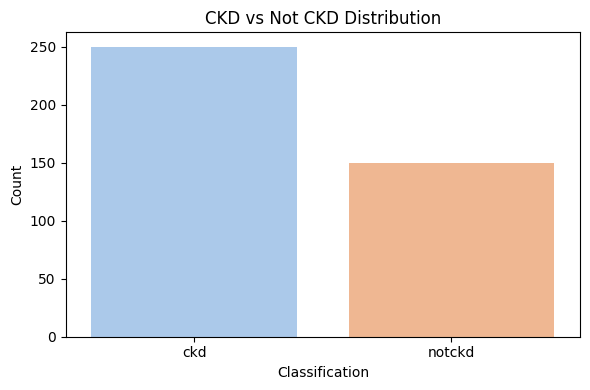

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean classification values (strip whitespace / hidden chars)
df['classification'] = df['classification'].str.strip().str.lower()

# Keep only ckd and notckd
df = df[df['classification'].isin(['ckd', 'notckd'])]

# Plot cleaned distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='classification', palette='pastel')
plt.title("CKD vs Not CKD Distribution")
plt.xlabel("Classification")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


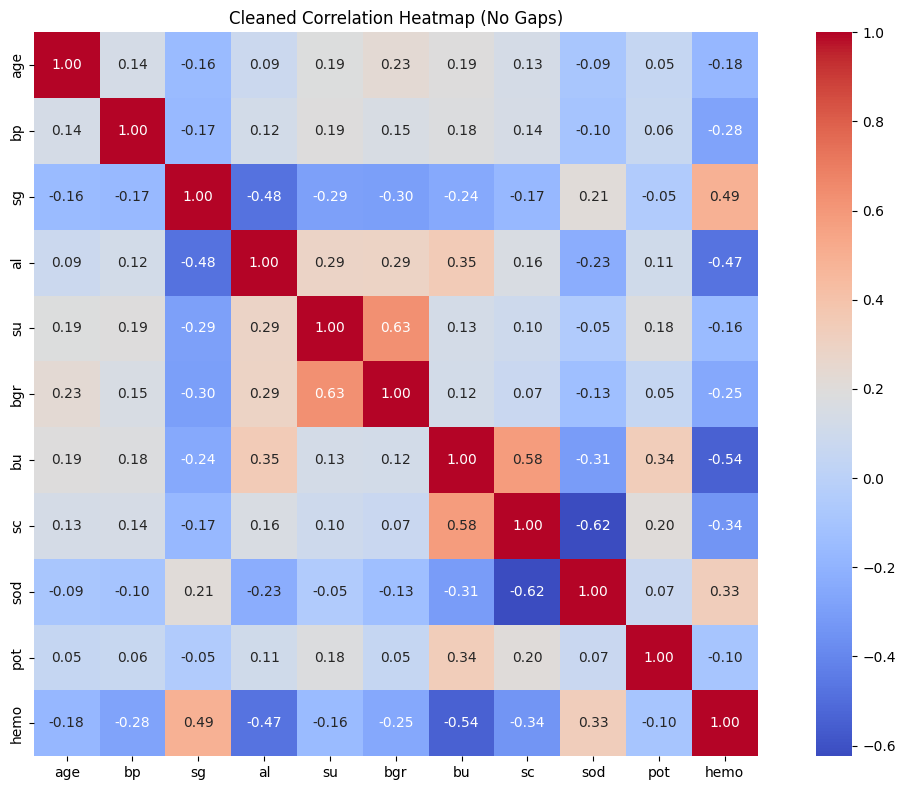

In [11]:


# Step 1: Drop constant columns
from sklearn.feature_selection import VarianceThreshold

# Extract numeric features
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Drop near-constant columns
selector = VarianceThreshold(threshold=0.0)
numeric_filtered = numeric_df.loc[:, selector.fit(numeric_df).get_support()]

# Step 2: Drop columns that still produce NaN correlations
clean_corr_matrix = numeric_filtered.corr().dropna(axis=0, how='any').dropna(axis=1, how='any')

# Step 3: Plot the cleaned heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(clean_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Cleaned Correlation Heatmap (No Gaps)")
plt.tight_layout()
plt.show()


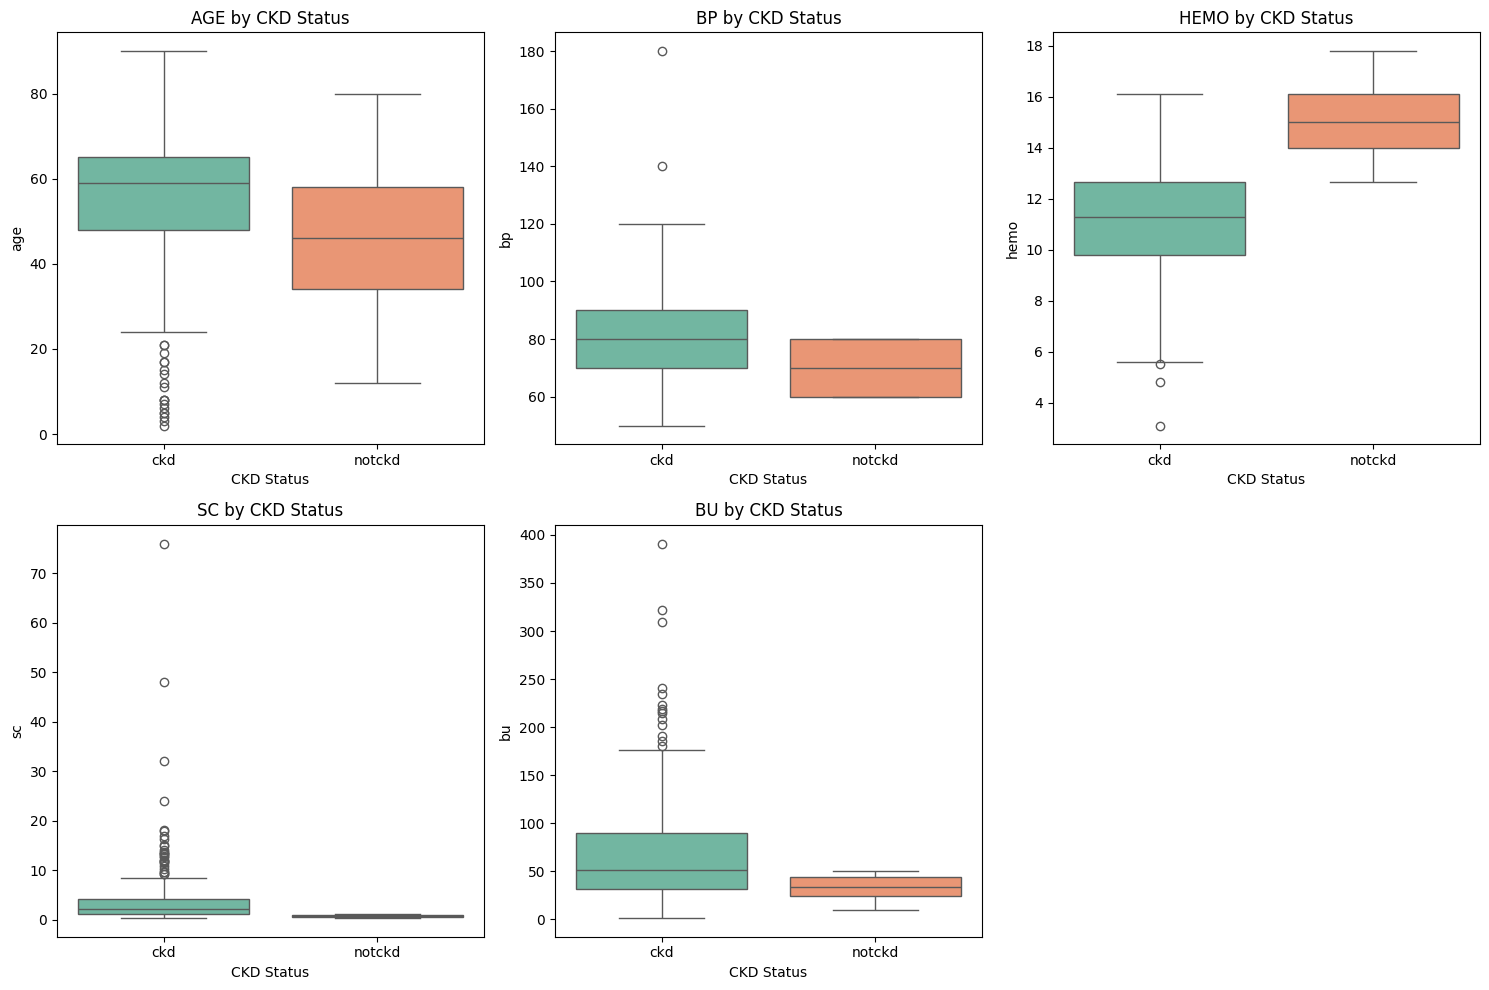

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean classification labels
df['classification'] = df['classification'].str.strip().str.lower()
df = df[df['classification'].isin(['ckd', 'notckd'])]

# Step 3: Box plots comparing distributions across CKD and Not CKD
features_to_plot = ['age', 'bp', 'hemo', 'sc', 'bu']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='classification', y=feature, palette='Set2')
    plt.title(f"{feature.upper()} by CKD Status")
    plt.xlabel("CKD Status")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


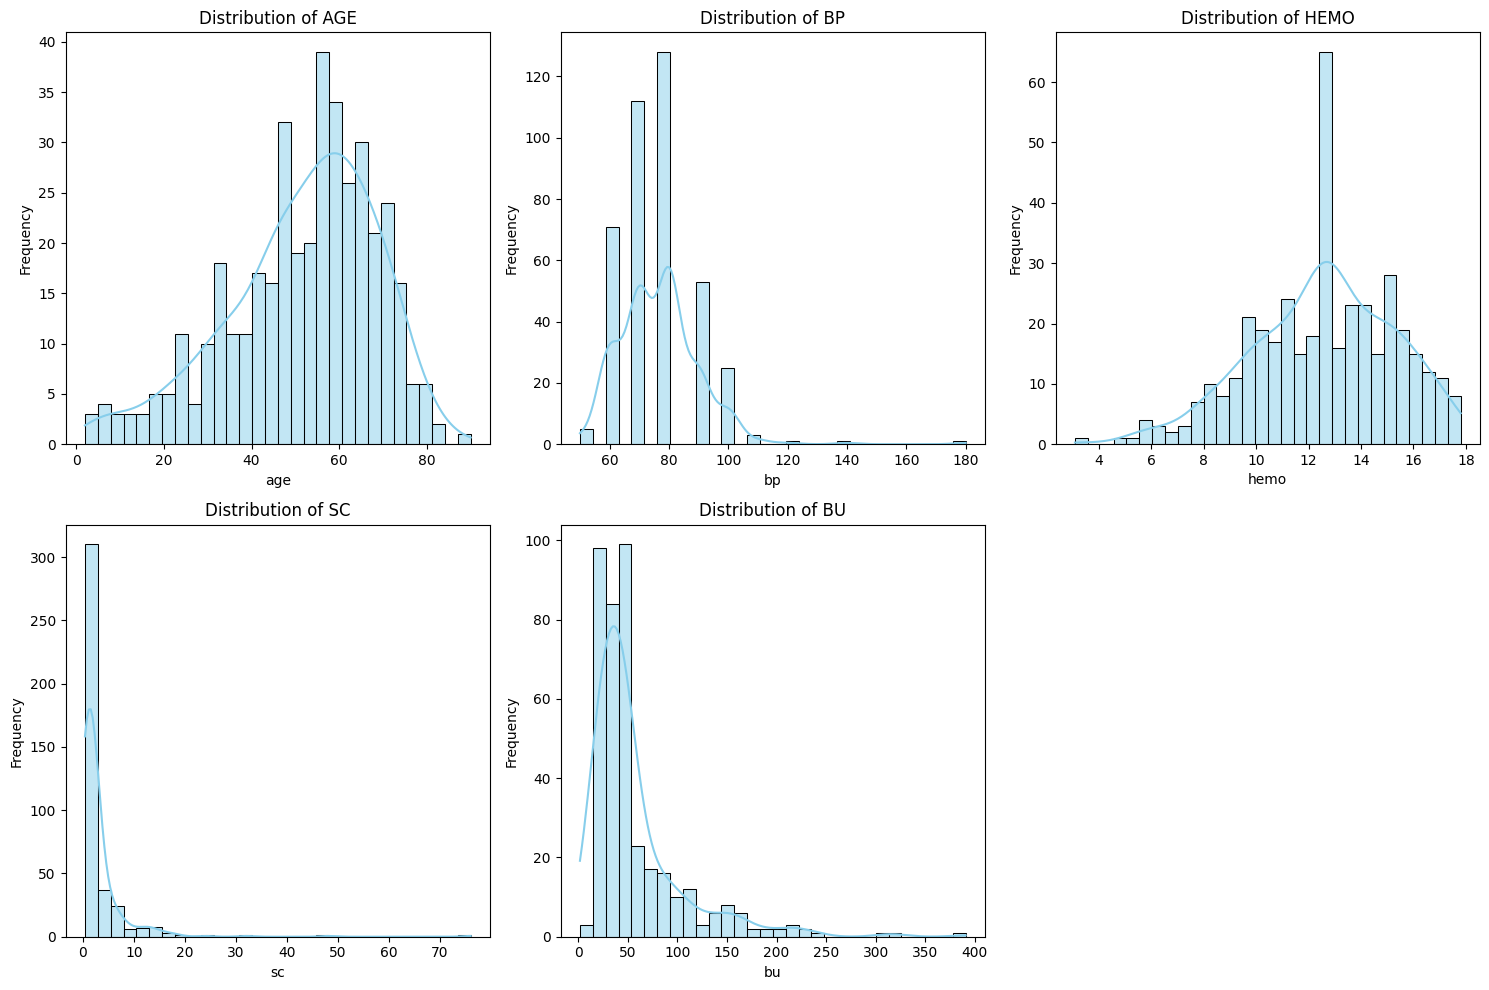

In [13]:
# Step 4: Histograms of key numerical features

key_features = ['age', 'bp', 'hemo', 'sc', 'bu']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=feature, kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {feature.upper()}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [14]:
# Function to remove outliers and print how many were removed
def remove_outliers_iqr_verbose(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = dataframe.shape[0]
    filtered_df = dataframe[(dataframe[column] >= lower) & (dataframe[column] <= upper)]
    after = filtered_df.shape[0]
    print(f"{column}: {before - after} outliers removed")
    return filtered_df

# Apply outlier removal and print results
for col in num_cols:  # using num_cols from previous cell
    df = remove_outliers_iqr_verbose(df, col)

# Final shape after all outlier removals
print(f"\nFinal dataset shape: {df.shape}")


age: 10 outliers removed
bp: 33 outliers removed
sg: 6 outliers removed
al: 47 outliers removed
su: 31 outliers removed
bgr: 22 outliers removed
bu: 31 outliers removed
sc: 17 outliers removed
sod: 0 outliers removed
pot: 0 outliers removed
hemo: 0 outliers removed

Final dataset shape: (203, 25)


In [15]:
pip install imblearn


In [16]:
# Separate minority and majority classes
minority_class = df[df['classification'] == 'ckd']
majority_class = df[df['classification'] == 'notckd']

# Upsample minority class
minority_upsampled = minority_class.sample(n=len(majority_class), replace=True, random_state=42)

# Combine to form balanced dataset
df_balanced = pd.concat([majority_class, minority_upsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print(df_balanced['classification'].value_counts())


classification
ckd       150
notckd    150
Name: count, dtype: int64


In [17]:
# Step: Split the balanced dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare features and target
df_split = df_balanced.copy()
X = df_split.drop(columns=[ 'classification'])
y = df_split['classification']

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and test sets (80/20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Output the shape of splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((240, 143), (60, 143), (240,), (60,))

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Train a Logistic Regression model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Predict on test set
y_pred_log = log_model.predict(X_test)




# Evaluate model
log_report = classification_report(y_test, y_pred_log, target_names=le.classes_)
log_conf_matrix = confusion_matrix(y_test, y_pred_log)
log_accuracy = accuracy_score(y_test, y_pred_log)

print(log_report)
print("Confusion Matrix:\n", log_conf_matrix)
print("Accuracy:", log_accuracy)



              precision    recall  f1-score   support

         ckd       0.97      1.00      0.98        30
      notckd       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

Confusion Matrix:
 [[30  0]
 [ 1 29]]
Accuracy: 0.9833333333333333


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the model
dt_model = DecisionTreeClassifier(random_state=32)
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
dt_report = classification_report(y_test, y_pred_dt, target_names=le.classes_)
dt_conf_matrix = confusion_matrix(y_test, y_pred_dt)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

# Print formatted results
print(" Decision Tree Classifier Evaluation")
print("-" * 45)
print(" Classification Report:")
print(dt_report)

print(" Confusion Matrix:")
print(dt_conf_matrix)

print(" Accuracy Score: {:.2f}%".format(dt_accuracy * 100))


 Decision Tree Classifier Evaluation
---------------------------------------------
 Classification Report:
              precision    recall  f1-score   support

         ckd       0.97      0.97      0.97        30
      notckd       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

 Confusion Matrix:
[[29  1]
 [ 1 29]]
 Accuracy Score: 96.67%


In [20]:
from sklearn.svm import SVC

# Train a Support Vector Machine (SVM) classifier
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate model
svm_report = classification_report(y_test, y_pred_svm, target_names=le.classes_)
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Print nicely
print(" Support Vector Machine (SVM) Evaluation")
print("-" * 45)
print(" Classification Report:")
print(svm_report)

print(" Confusion Matrix:")
print(svm_conf_matrix)

print(" Accuracy Score: {:.2f}%".format(svm_accuracy * 100))


 Support Vector Machine (SVM) Evaluation
---------------------------------------------
 Classification Report:
              precision    recall  f1-score   support

         ckd       0.79      0.50      0.61        30
      notckd       0.63      0.87      0.73        30

    accuracy                           0.68        60
   macro avg       0.71      0.68      0.67        60
weighted avg       0.71      0.68      0.67        60

 Confusion Matrix:
[[15 15]
 [ 4 26]]
 Accuracy Score: 68.33%


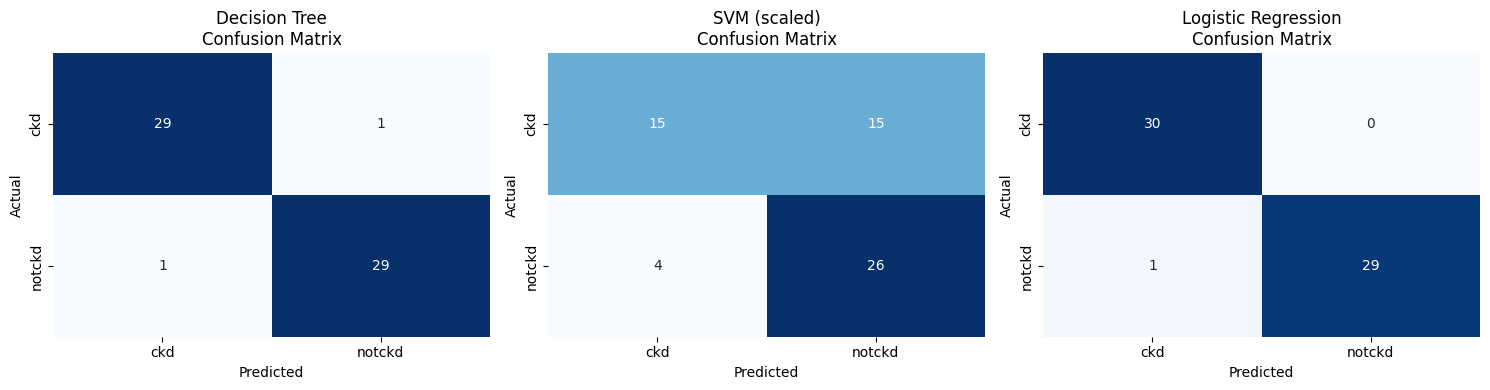

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrices from previous model predictions
conf_matrices = {
    "Decision Tree": dt_conf_matrix,
    "SVM (scaled)": svm_conf_matrix,
    "Logistic Regression": log_conf_matrix
}

# Plot confusion matrices
plt.figure(figsize=(15, 4))

for i, (model_name, matrix) in enumerate(conf_matrices.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{model_name}\nConfusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


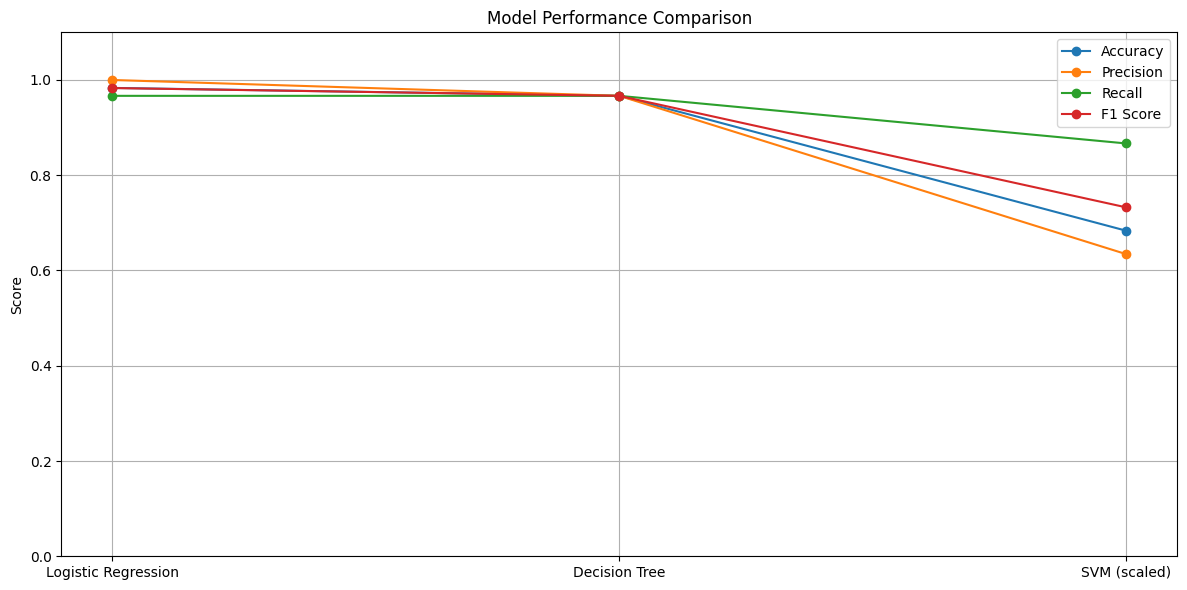

In [22]:
# Plot model performance comparison (accuracy, precision, recall, f1)
from sklearn.metrics import precision_score, recall_score, f1_score

# Reuse the previously calculated metrics
performance_metrics = {
    "Model": ["Logistic Regression", "Decision Tree", "SVM (scaled)"],
    "Accuracy": [log_accuracy, dt_accuracy, svm_accuracy],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_svm)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_svm)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_svm)
    ]
}

# Create a DataFrame
perf_df = pd.DataFrame(performance_metrics)

# Plot the performance comparison
plt.figure(figsize=(12, 6))
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
for metric in metrics:
    plt.plot(perf_df["Model"], perf_df[metric], marker='o', label=metric)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# hyperparameter tuning

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Scale the features (very important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Create a GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

# Best model
best_svm = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate
y_pred_best_svm = best_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred_best_svm, target_names=le.classes_))


Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

         ckd       0.97      1.00      0.98        30
      notckd       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Base estimator (set random_state for reproducibility)
dt_base = DecisionTreeClassifier(random_state=42)

# Parameter grid (tune depth, split/leaf sizes, criterion, and minimal cost-complexity pruning)
param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 3, 5, 7, 9, 12],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": [0.0, 0.001, 0.01]  # post-pruning strength
}

# Grid search (5-fold CV, accuracy)
grid_dt = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid_dt,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Fit on TRAIN (no scaling needed)
grid_dt.fit(X_train, y_train)

# Best model
best_dt = grid_dt.best_estimator_
print("Best parameters (Decision Tree):", grid_dt.best_params_)

# Evaluate on TEST
y_pred_best_dt = best_dt.predict(X_test)
print("\nDecision Tree (Best) — Classification Report")
print(classification_report(y_test, y_pred_best_dt, target_names=le.classes_))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_best_dt))


Best parameters (Decision Tree): {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Decision Tree (Best) — Classification Report
              precision    recall  f1-score   support

         ckd       0.97      1.00      0.98        30
      notckd       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

Confusion Matrix:
 [[30  0]
 [ 1 29]]
Accuracy: 0.9833333333333333


<Figure size 1200x600 with 0 Axes>

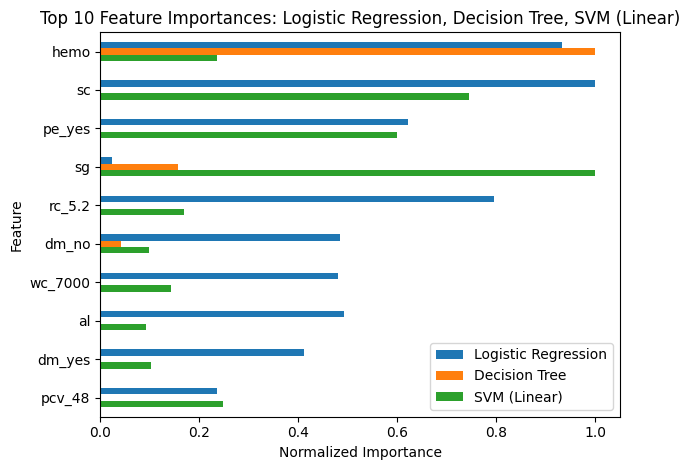

In [24]:
import numpy as np

# Retrain SVM with linear kernel to extract feature importance
from sklearn.svm import SVC

# Train SVM with linear kernel and scaled data
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# Extract importances
log_importances = np.abs(log_model.coef_[0])
dt_importances = dt_model.feature_importances_
svm_importances = np.abs(svm_linear.coef_[0])

# Assemble into DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Logistic Regression': log_importances,
    'Decision Tree': dt_importances,
    'SVM (Linear)': svm_importances
}).set_index('Feature')

# Normalize for comparison
importance_df = importance_df.div(importance_df.max())

# Select top features
top_features = importance_df.mean(axis=1).sort_values(ascending=False).head(10).index

# Plot
plt.figure(figsize=(12, 6))
importance_df.loc[top_features].plot(kind='barh')
plt.title("Top 10 Feature Importances: Logistic Regression, Decision Tree, SVM (Linear)")
plt.xlabel("Normalized Importance")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()
